# Building Agents with LangGraph

## ⭐ Overview

This notebook walks through building a **reactive agent workflow** using [LangGraph](https://python.langchain.com/docs/langgraph/)—a Python framework for designing **stateful, multi-node computation graphs** to manage LLM reasoning, tool usage, and memory.

The tutorial demonstrates how to:

- 🧰 **Define tools** for arithmetic operations (`add`, `multiply`, `divide`)
- 🤖 **Construct an agent** using a language model from **OpenRouter**
- 🔁 **Control flow** using a graph with condition-based routing between assistant responses and tool calls
- ⚙️ **Invoke tools** based on the LLM’s reasoning and continue looping until no further computation is needed
- ✍️ **Summarize conversations** at the end of the graph to manage long interaction histories
- 🗂️ **Persist memory** using a thread-based checkpoint system for multi-turn, long-lived agent interactions


In [2]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_openai
%pip install seaborn matplotlib pandas

### Environment Configuration

We'll load environment variables from a `.env` file, which should contain your API keys and other configuration settings.

In [3]:
import getpass
import os

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

###  2. Setting Up the State Graph
 
We'll first create a **simple chatbot** using LangGraph. This chatbot will respond directly to user messages. Though minimal, it introduces the **core concepts** of building with LangGraph. By the end of this section, you'll have built a rudimentary chatbot powered by a stateful graph.

LangGraph builds agents as **state machines**, where each state holds data (like messages), and each node modifies that state. The graph you define controls how messages flow and how the LLM or tools act on them.

We start by creating a `StateGraph`. This object defines the structure of our chatbot, including:

- **Nodes**: Representing the LLM and any functions (tools) the agent can call  
- **Edges**: Specifying how the chatbot transitions between nodes

The first step is to define the **State** — the structure of the data your graph will carry and update over time. In our example, the state has a single key: `messages`. This key is annotated with a built-in reducer function `add_messages`, which ensures that messages are **appended** rather than overwritten as the conversation progresses.

Our graph can now handle two key tasks:

1. Each node receives the current state as input and returns an update to the state.
2. Updates to `messages` are accumulated (not overwritten), thanks to the `add_messages` reducer.

Any key in the state **without** a reducer annotation will default to being overwritten instead of accumulated.

This structure is powerful for multi-step LLM workflows where message history needs to be preserved and tools or models interact over several turns.

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## 3. Creating the LLM-powered Assistant

We'll use the OpenAI (or compatible) API through OpenRouter to access Llama 3.1.

In [5]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Use OPENROUTER_API_KEY for OpenRouter service
llm = ChatOpenAI(
            openai_api_key=os.getenv("OPENROUTER_API_KEY"),
            openai_api_base=os.getenv("OPENROUTER_BASE_URL"),
            model_name="meta-llama/llama-3.1-8b-instruct")

In [6]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Use OPENROUTER_API_KEY for OpenRouter service
llm = ChatOpenAI(
            openai_api_key=os.getenv("OPENROUTER_API_KEY"),
            openai_api_base=os.getenv("OPENROUTER_BASE_URL"),
            model_name="meta-llama/llama-3.1-8b-instruct")

### 3.1 Creating Tools

Tools are functions that agents can use to interact with external systems or perform specific operations. Below, we create simple arithmetic tools that our agent will use to perform calculations.

Each tool is decorated with `@tool` which provides metadata that helps the LLM understand how to use it properly.

In [7]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

### 3.2: Create the Assistant Node and bind the tools

Next, we define the **assistant node**, which represents the LLM's reasoning and response capabilities. This node is responsible for generating replies based on the current state of the conversation.

The assistant function follows a key LangGraph pattern:

- It **accepts the current `State`** as input
- It **returns a dictionary** containing the updated `messages` under the `"messages"` key

This is the **standard interface** for any LangGraph node — take in state, return a partial update to state.

In this case, the assistant calls the LLM using all prior messages in the state (along with a fixed system message) and appends the model's response to the message history.

Since the `messages` key in our state uses the `add_messages` reducer, any messages returned by the assistant will be **appended** to the existing list — not overwrite it. This accumulation is essential for maintaining context over multiple turns.

By binding the LLM to tools, we also enable it to detect when to call external functions (e.g., `add`, `multiply`, `divide`) based on user queries. LLM determines, if tool use is required!

This assistant node becomes the **core loop** of our agent: reading messages, responding with reasoning or tool calls, and updating the state for the next step.


In [8]:
# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# System prompt
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## 🔁 4. Building the ReAct Graph

Let's construct a ReAct (Reasoning + Acting) graph that enables our agent to repeatedly reason and act until it solves the problem.


Now that we’ve defined the building blocks — the assistant node, tool functions, and state — it’s time to **assemble the full LangGraph** by adding nodes and defining the control flow between them.

This step creates a **ReAct-style agent loop**, where the assistant decides whether to call a tool or respond directly, looping until the task is complete.

#### 🧩 Adding Nodes

We start by adding two nodes to the graph:

- `"assistant"`: The node that invokes the LLM and makes decisions
- `"tools"`: A special `ToolNode` that executes the bound external functions

#### 🔗 Defining Edges (Transitions)

Edges define the logic of the conversation flow:

- `START → assistant`: Entry point for the graph
- `assistant → tools` or `assistant → END`: Conditional path based on whether the LLM decides to invoke a tool
- `tools → assistant`: If a tool was used, return to the assistant with updated state

The **`tools_condition`** function checks if the LLM's output includes a tool call. If yes, the flow routes to the `tools` node; otherwise, it ends.

#### 🚦 Entry and Exit Points

- `START`: Marks where execution begins each time the graph is run
- `END`: Marks where the graph can terminate

#### ⚙️ Compiling the Graph

Once all nodes and edges are added, you must call `.compile()` on the `StateGraph` to convert it into an executable `CompiledGraph`. This object can now be used to **invoke** the graph on a given state.

#### 🖼️ Visualizing the Graph

You can inspect the structure of the graph using:

- `.get_graph()` — returns a visualization-ready object
- `.draw_ascii()`, `.draw_mermaid_png()`, etc. — different ways to render the graph visually

> Note: Visual rendering (like PNG or Mermaid diagrams) requires additional dependencies, which are often installed via `graphviz` or specific LangGraph extras.

This step gives you a powerful and transparent way to visualize and debug your agentic workflows.


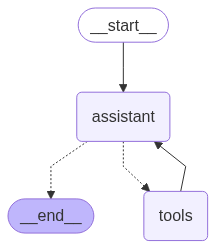

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## 5. Persistent Memory with Checkpointing 

Our assistent can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations — a key capability for useful AI agents.

LangGraph solves this problem using **persistent checkpointing**. By providing a `checkpointer` when compiling the graph, and a `thread_id` when invoking it, LangGraph automatically **saves the state after each step**. On future calls using the same `thread_id`, the graph **resumes from its last state**, enabling seamless multi-turn dialogue.

This is far more powerful than traditional “chat memory.” With checkpointing, you can also:
- Resume workflows after failure
- Perform error recovery
- Enable human-in-the-loop approval
- Implement time-travel-like behavior in the agent's reasoning path

Let’s break this down in two parts: enabling checkpointing and invoking the graph with persistent memory.

---


### 💬 Testing Multi-Turn Math without Memory

With tools now integrated, we can start testing multi-step arithmetic interactions. But without memory, each interaction is isolated — the chatbot won’t remember earlier messages.

In this section, we compare two runs of the same mathematical flow:

1. First, we run two back-to-back prompts: one asking to add two numbers, and another that refers to the previous result ("Multiply that by 2").  
   Without memory, the chatbot doesn’t retain context — the second query is treated independently and fails to use the previous result.

2. Then, we re-run the same flow, but this time using LangGraph’s `MemorySaver` to enable checkpointing.  
   By passing a `thread_id`, the state (including prior messages and tool results) is saved and reused. The chatbot correctly remembers the addition result and uses it in the multiplication step.

This confirms that **persistent memory works** as expected, and that LangGraph’s checkpointing system allows for coherent, multi-turn conversations — a critical requirement for building reliable agents.


In [10]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_GYZPinhxExUrkwd2yTmZDg1A)
 Call ID: call_GYZPinhxExUrkwd2yTmZDg1A
  Args:
    a: 2
    b: 5
  multiply (call_AtPrQUALUSaOXYXWR8z6ruzW)
 Call ID: call_AtPrQUALUSaOXYXWR8z6ruzW
  Args:
    a: 14
    b: 2
  add (call_piCCdoDkwIOcw837naIONHPc)
 Call ID: call_piCCdoDkwIOcw837naIONHPc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: divide

0.4
================================= Tool Message =================================
Name: multiply

28
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

That's the step-by-step process!


### Example 2: Simple Addition
A simpler example that only requires a single tool call.

In [11]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


### Example 3: Follow-up Question
This example tests whether the agent can understand context from previous operations. However, without memory between invocations, it won't have access to previous results. We'll fix this in the next section.

In [12]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================



Result: multiply=a*5*2=10
Tool Calls:
  multiply (call_8ftWEjzYgxHFuagmvi1KYRFF)
 Call ID: call_8ftWEjzYgxHFuagmvi1KYRFF
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================


### 🧠 5.2.  Enable Checkpointing with a MemorySaver

We begin by using the `MemorySaver` checkpointer from LangGraph:

- This in-memory checkpointer is perfect for tutorials or prototypes
- In production, you’d replace it with a persistent store like `SqliteSaver` or `PostgresSaver`

> 📘 *API Reference: [`MemorySaver`](https://docs.langgraph.com/api/langgraph.checkpoint.memory.MemorySaver.html)*


In [13]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

# Specify a thread
config = {"configurable": {"thread_id": "1"}}

### 💬 Let's verify!

In [14]:
# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_qMdACifMoTH1rjIAcVVz57hN)
 Call ID: call_qMdACifMoTH1rjIAcVVz57hN
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The function 'add' has been called with the required parameters 'a' and 'b' set to 3 and 4 respectively. The result of this operation is 7.


In [15]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_qMdACifMoTH1rjIAcVVz57hN)
 Call ID: call_qMdACifMoTH1rjIAcVVz57hN
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The function 'add' has been called with the required parameters 'a' and 'b' set to 3 and 4 respectively. The result of this operation is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Zq53ISJwWDg9XDmFOuu4L7Cr)
 Call ID: call_Zq53ISJwWDg9XDmFOuu4L7Cr
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: m

## 6. Enhanced Graph with Summarization

Next, we'll build an enhanced version of our graph that adds conversation summarization capabilities. This is useful for:
- Maintaining context while reducing token usage
- Providing a concise overview of the conversation
- Simulating long-term memory through summarization

We add a new node that summarizes the conversation when the assistant is done using tools.

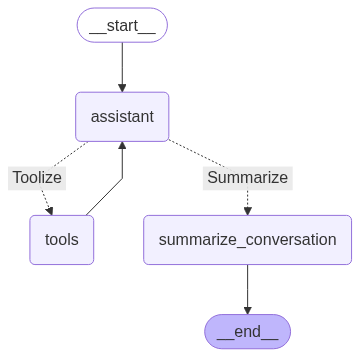

In [16]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, RemoveMessage
from IPython.display import Image, display

# LLM
model = llm  # use your LLM object

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs. Always Summerize the conversation before ending.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Summarization node
def summarize_conversation(state: MessagesState) -> dict:
    summary = state.get("summary", "")
    
    # Always prompt for summary
    summary_prompt = "Create a concise summary of the conversation above:"
    summary_request = HumanMessage(content=summary_prompt)
    
    # Use previous messages + summary request
    messages = state["messages"] + [summary_request]
    response = model.invoke(messages)

    # Simulate windowing: delete old messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    
    return {
        "summary": response.content,
        "messages": delete_messages
    }

# Build graph
builder = StateGraph(MessagesState)

# Replace tools_condition to always summarize
def tools_or_summarize(state: MessagesState):
    if tools_condition(state) == "tools":
        return "Toolize"
    return "Summarize"

# Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("summarize_conversation", summarize_conversation)

# Edges - Fixed: mapping keys must match function return values
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_or_summarize,
    {
          "Toolize": "tools",                     # Key matches function return
          "Summarize": "summarize_conversation"  # Key matches function return
     })
builder.add_edge("tools", "assistant")  # loop back
builder.add_edge("summarize_conversation", END)

# Compile and show
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## 6. Testing the Summarization

Let's test our enhanced graph with a pre-built conversation about traveling to Italy. This will demonstrate how the system generates a summary from a longer conversation.

The conversation includes multiple messages about different cities in Italy, travel timing, and recommendations. Our agent will process this and create a concise summary.

In [17]:
messages = [
    HumanMessage(content="Hi, I'm planning a trip to Italy. I'm really excited about it."),
    HumanMessage(content="I want to visit Rome for its history. Rome has so much to see."),
    HumanMessage(content="Also thinking of Florence, because I heard it's great for art."),
    AIMessage(content="Yes! Florence has the Uffizi Gallery and amazing Renaissance art."),
    HumanMessage(content="Oh and Venice too. I've always wanted to ride a gondola in Venice."),
    AIMessage(content="Venice is beautiful and unique. A gondola ride is a must!"),
    HumanMessage(content="What's the best time of year to go to Italy? I don't like extreme heat."),
    AIMessage(content="Spring (April to June) and Fall (September to October) are ideal."),
    HumanMessage(content="But I'll only have 3 days in Italy. What should I prioritize?"),
    AIMessage(content="In Rome, visit the Colosseum, Vatican City, and the Pantheon."),
    AIMessage(content="In Florence, see Michelangelo's David and the Duomo."),
    AIMessage(content="In Venice, take a gondola ride and visit St. Mark's Basilica."),
    HumanMessage(content="Thanks! I'll plan my trip around those recommendations.")
]

config = {"configurable": {"thread_id": "long-trip-convo"}}

result = react_graph.invoke({"messages": messages}, config)

# Show final result
for msg in result["messages"]:
    print(f"[{msg.type.upper()}] {msg.content}")


[TOOL] 5.0
[AI] It seems you entered a value for the set division function instead of asking a question. If you're looking for a calculation, I'm here to help.

If you'd like to calculate something related to your trip, such as the cost of accommodations or transportation, feel free to ask.

To summarize, we discussed planning a 3-day trip to Italy, prioritizing specific attractions in Rome, Florence, and Venice, and didn't perform any arithmetic calculations.


## ✅ Conclusion

In this tutorial, we explored how to build a tool-using, multi-turn chatbot using **LangGraph** — a framework for structuring LLM workflows as stateful computation graphs.

We walked through:

- Defining and registering arithmetic tools  
- Creating assistant nodes that interact with an LLM (OpenRouter or Claude)  
- Constructing a **ReAct-style graph loop** for reasoning + tool use  
- Adding a **summarization node** to manage long conversations  
- Enabling **persistent memory** through checkpointing for multi-turn interactions

By the end, we demonstrated how LangGraph can handle complex, stateful workflows — making it ideal for building **reliable**, **tool-augmented**, and **memory-aware** AI agents.
